In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm, truncnorm
import corner
import arviz as az
import seaborn as sns
import pymc as pm
import emcee
from scipy.stats import gaussian_kde
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax import random
from numpyro import infer
numpyro.set_host_device_count(2) # let's use 2 cores!

In [10]:
df = pd.read_csv('../data/gaiadr3_solar_neighborhood.csv')
df

,mg,bp_rp,parallax
0,10.390250,2.731872,10.000008
1,8.608481,2.025819,10.000029
2,4.267759,0.880858,10.000032
3,10.506658,2.649735,10.000066
4,12.077941,2.940875,10.000111
...,...,...,...
227624,11.758283,2.834036,336.026602
227625,9.521769,2.215609,392.752945
227626,14.129570,4.184836,415.179416
227627,11.883816,2.833697,546.975940


In [11]:
# Filtering parallax > 40
nearby_sel = df.parallax > 40
nearby_df = df[nearby_sel]

# from question slope and intercept 
x1, y1 = 0, 8
x2, y2 = 3, 16.5
m_div = (y2 - y1) / (x2 - x1)  
b_div = y1 - m_div * x1  

# Apply the condition where 'mg' is less than the line defined by 'bp_rp'
afterExclude_df = nearby_df[nearby_df['mg'] < (m_div * nearby_df['bp_rp'] + b_div)]

# Print the filtered DataFrame
print(afterExclude_df)


               mg     bp_rp    parallax
223559  11.544313  2.992254   40.002314
223560  13.563787  3.794676   40.004848
223561  10.197586  2.492932   40.007115
223562  12.769197  3.373776   40.014745
223563  12.413716  3.135756   40.019696
...           ...       ...         ...
227624  11.758283  2.834036  336.026602
227625   9.521769  2.215609  392.752945
227626  14.129570  4.184836  415.179416
227627  11.883816  2.833697  546.975940
227628  13.411743  3.804580  768.066539

[3821 rows x 3 columns]


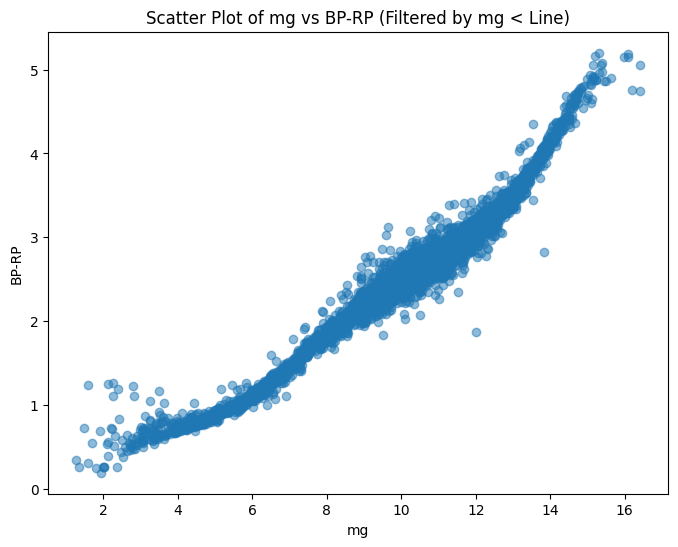

In [13]:
# plotting the filtered data
plt.figure(figsize=(8, 6))
plt.scatter(afterExclude_df['mg'], afterExclude_df['bp_rp'], alpha=0.5)

plt.xlabel('mg')
plt.ylabel('BP-RP')
plt.title('Scatter Plot of mg vs BP-RP (Filtered by mg < Line)')
plt.show()

In [17]:
def linear_model(BP_RP=None, MG=None):
    # priors
    m = numpyro.sample('m', dist.Normal(scale=10))
    b = numpyro.sample('b', dist.Normal(loc=300, scale=100))
    σ = numpyro.sample('sigma', dist.HalfNormal(scale=20)) 

    # Define the mean of the normal likelihood
    μ = numpyro.deterministic("μ", m * BP_RP + b)

    # Likelihood (sampling distribution) of observations
    with numpyro.plate("afterExclude_df", len(MG)):
         obs = numpyro.sample('BP_RP', dist.Normal(loc=μ, scale=σ), obs=MG)


In [23]:
# Preparing data
BP_RP = afterExclude_df['bp_rp'].values
MG = afterExclude_df['mg'].values

# Generate a starting key, which we'll split for later operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

kernel = infer.NUTS(linear_model)
num_samples = 5000
mcmc = infer.MCMC(
    kernel,
    num_chains=2,
    num_warmup=1000,
    num_samples=num_samples)
mcmc.run(rng_key_,
         BP_RP, 
         MG)
mcmc.print_summary()

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      2.58      0.03      2.59      2.54      2.63   3673.72      1.00
         m      2.94      0.01      2.94      2.92      2.95   3718.25      1.00
     sigma      0.57      0.01      0.57      0.56      0.58   4934.62      1.00

Number of divergences: 0


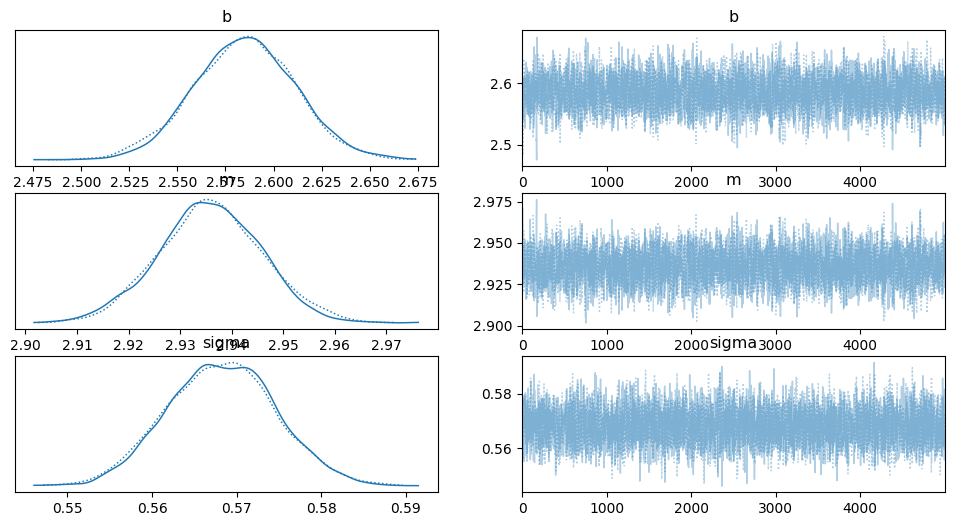

In [24]:
az.plot_trace(mcmc, var_names=["~μ"]);

In [25]:
samples1 = mcmc.get_samples()

In [29]:
print(MG)

[11.54431342 13.56378674 10.19758631 ... 14.12957018 11.88381561
 13.41174307]


In [ ]:
tgrid = np.linspace(BP_RP.min(), BP_RP.max(), 20)

post_pred_samples = infer.Predictive(linear_model, samples1)(
    random.PRNGKey(1), BP_RP=tgrid,
)
post_pred_y = post_pred_samples["bp_rp"]
post_pred_y.shape

In [ ]:
plt.plot(MG, BP_RP);
for i in random.choice(rng_key, len(post_pred_y), (50,)):
    plt.plot(tgrid, post_pred_samples['μ'][i], color='black', alpha=0.1)
    plt.scatter(tgrid, post_pred_y[i], color='skyblue', marker=',', s=1, alpha=.1)

In [20]:
def quad_model(BP_RP=None, MG=None):
    # priors
    a = numpyro.sample('a', dist.Normal(scale=100))
    b = numpyro.sample('b', dist.Normal(scale=100))
    c = numpyro.sample('c', dist.Normal(scale=1000))

    σ = numpyro.sample('scatter', dist.HalfNormal(scale=20))

    # Define the mean of the normal likelihood
    μ = numpyro.deterministic("μ",  a*BP_RP**2 + b*BP_RP+ c) #I have commented out this line to make you pasue and reflect. What is this line doing? Does it make sense?

    # Likelihood (sampling distribution) of observations
    with numpyro.plate("afterExclude_df", len(MG)):
        obs = numpyro.sample('BP_RP', dist.Normal(loc=μ, scale=σ), obs=MG)

In [21]:
# Generate a starting key, which we'll split for later operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

kernel = infer.NUTS(quad_model)
num_samples = 5000
mcmc = infer.MCMC(
    kernel,
    num_chains=2,
    num_warmup=1000,
    num_samples=num_samples)
mcmc.run(rng_key_,
         BP_RP,
         MG)
mcmc.print_summary()

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.30      0.01     -0.30     -0.31     -0.29   2719.42      1.00
         b      4.40      0.03      4.40      4.35      4.46   2565.25      1.00
         c      1.06      0.04      1.06      1.00      1.12   2577.80      1.00
   scatter      0.45      0.01      0.45      0.44      0.46   4051.34      1.00

Number of divergences: 0


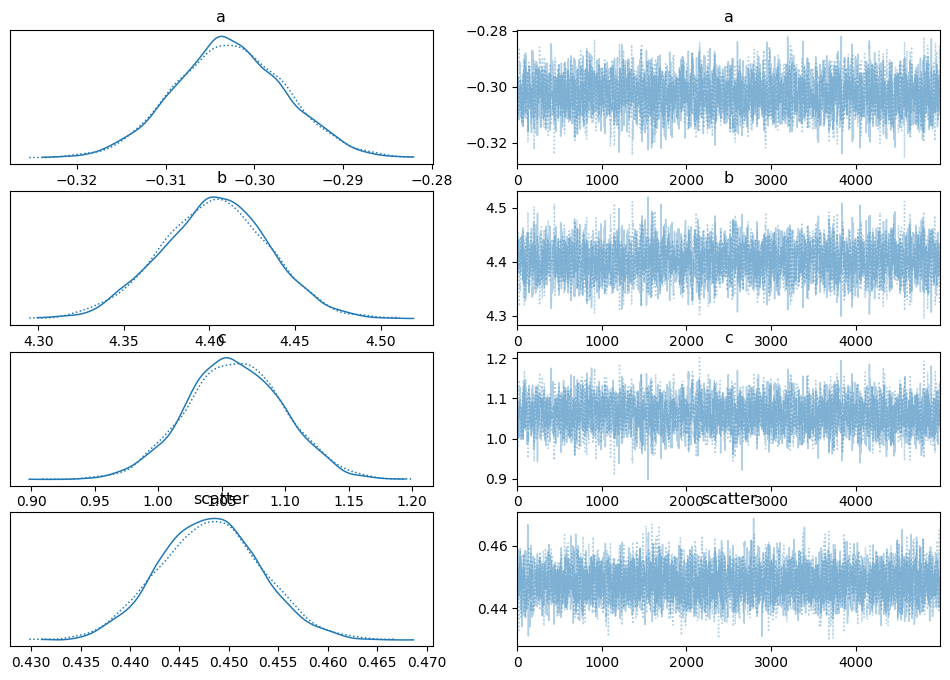

In [22]:
az.plot_trace(mcmc, var_names=["~μ"]);